In [3]:
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
df = pd.read_csv('wine-reviews.csv', usecols= ["country", "description", "points", "price", "province", "variety", "winery"])
# label the the description so we know if it is a good wine or not
df['label'] = df['points'].apply(lambda score: 1 if score >= 90 else 0)
# cleaning the data
# replace null values with the mean
df['price'].fillna((df['price'].mean()), inplace=True)

**Relationship between the points and price**

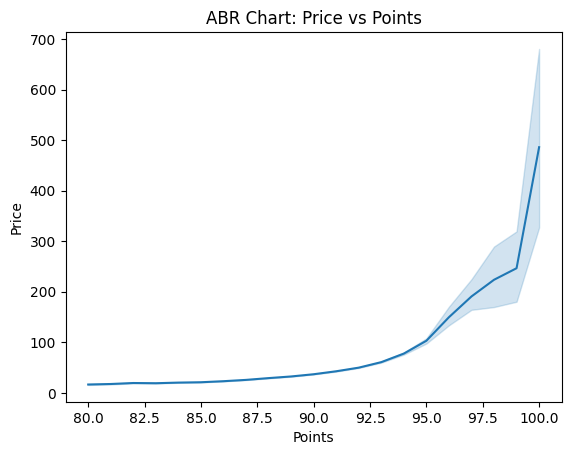

In [7]:

sns.lineplot(data=df, x='points', y='price')
plt.xlabel('Points')
plt.ylabel('Price')
plt.title('ABR Chart: Price vs Points')
plt.show()

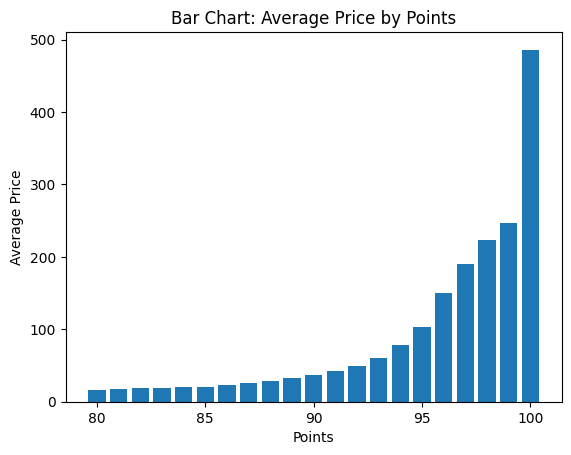

In [8]:

grouped = df.groupby('points')['price'].mean().reset_index()
# Create a bar chart
plt.bar(grouped['points'], grouped['price'])
plt.xlabel('Points')
plt.ylabel('Average Price')
plt.title('Bar Chart: Average Price by Points')
plt.show()


**Splitting the Data**

In [9]:

data = df[["description", "label"]]
"""
Notes:
The sample() function is used to randomly shuffle the rows of the DataFrame.
frac=1 indicates that we want to include all the rows in the shuffled DataFrame.
np.split: combines the previous steps to split the shuffled DataFrame into three subsets based on the specified split points.
"""
train, val, test = np.split(data.sample(frac=1), [int(.8*len(data)), int(.9*len(data))])

In [10]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  df = dataframe.copy()
  labels = df.pop('label')
  df = df["description"]
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds


In [11]:
# convert to a tensorflow dataset
train_ds = df_to_dataset(train)
val_ds = df_to_dataset(val)
test_ds = df_to_dataset(test)


**Using a Pre-trained model**

In [ ]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, dtype = tf.string, trainable=True)
# vectorize the text data
hub_layer(list(train_ds)[0][0])


In [14]:
# create a model 
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

# model.evaluate(train_ds)
# model.evaluate(val_ds)


In [ ]:
history = model.fit(train_ds, validation_data=val_ds, epochs=10)

In [23]:
model.evaluate(test_ds)

13/13 [==============================] - 0s 22ms/step - loss: 0.4123 - accuracy: 0.8282


[0.41231226921081543, 0.828204333782196]

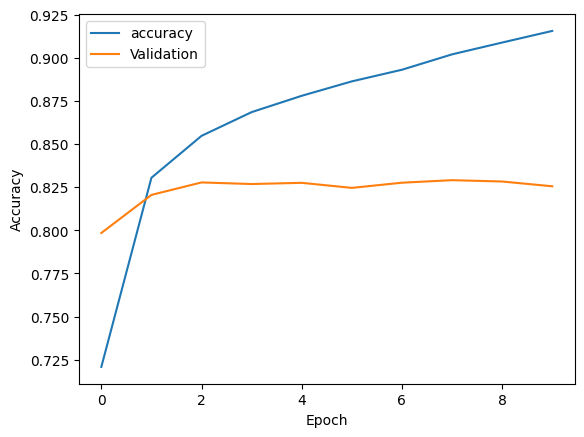

In [16]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = "Validation" )
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

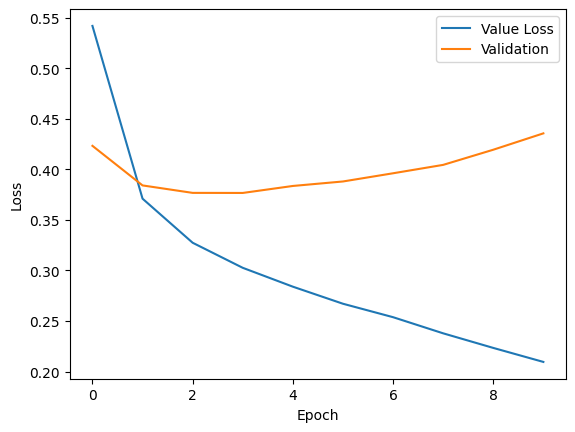

In [17]:
plt.plot(history.history['loss'], label='Value Loss')
plt.plot(history.history['val_loss'], label = "Validation" )
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Modifiying the Model

In [18]:
# adding dropout layers
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])


In [19]:
# reducing number of epochs for now
history = model.fit(train_ds, validation_data=val_ds, epochs=5)

Epoch 1/5
102/102 [==============================] - 16s 154ms/step - loss: 0.5648 - accuracy: 0.6823 - val_loss: 0.4519 - val_accuracy: 0.8072
Epoch 2/5
102/102 [==============================] - 16s 153ms/step - loss: 0.3908 - accuracy: 0.8400 - val_loss: 0.4039 - val_accuracy: 0.8190
Epoch 3/5
102/102 [==============================] - 16s 152ms/step - loss: 0.3284 - accuracy: 0.8701 - val_loss: 0.4109 - val_accuracy: 0.8159
Epoch 4/5
102/102 [==============================] - 15s 148ms/step - loss: 0.3017 - accuracy: 0.8820 - val_loss: 0.4197 - val_accuracy: 0.8156
Epoch 5/5
102/102 [==============================] - 15s 148ms/step - loss: 0.2862 - accuracy: 0.8891 - val_loss: 0.4309 - val_accuracy: 0.8194


In [20]:
model.evaluate(test_ds)

13/13 [==============================] - 0s 20ms/step - loss: 0.4123 - accuracy: 0.8282


[0.4123122990131378, 0.828204333782196]

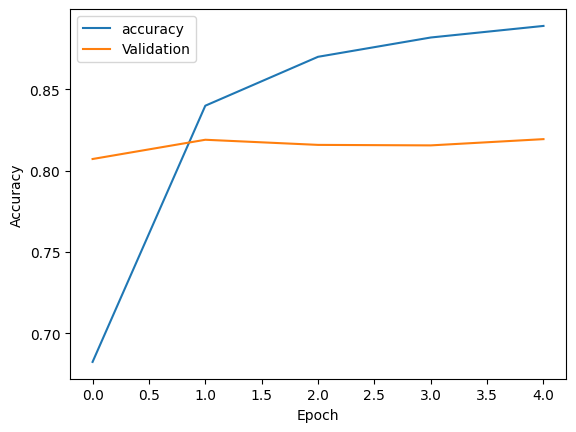

In [21]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = "Validation" )
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

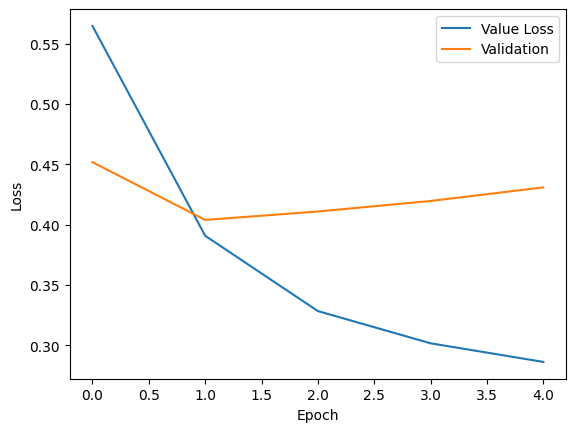

In [22]:
plt.plot(history.history['loss'], label='Value Loss')
plt.plot(history.history['val_loss'], label = "Validation" )
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()